In [27]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
import os

os.listdir('.//dataset')
myPath='.//dataset'
train_dataset  = pd.read_csv(os.path.join(myPath,'train_dataset.csv'), index_col = 'date')
validation_dataset  = pd.read_csv(os.path.join(myPath,'validation_dataset.csv'), index_col = 'date')


In [28]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 7).split(train_dataset, groups=train_dataset.index)
X_train_inds, X_test_inds = next(gss)

In [29]:
X=train_dataset.iloc[:,1:-2]
y=train_dataset.target

In [30]:
X_train=X.iloc[X_train_inds,:]
y_train=y.iloc[X_train_inds]
X_test=X.iloc[X_test_inds,:]
y_test=y.iloc[X_test_inds]

In [31]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRanker

In [32]:
groups=X_train.groupby('date').size().to_frame('size')['size'].to_numpy()
groups_eval=X_test.groupby('date').size().to_frame('size')['size'].to_numpy()

In [33]:
model = xgb.XGBRanker(  
    tree_method='gpu_hist',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.05,
    colsample_bytree=0.75, 
    eta=0.05, 
    max_depth=4, 
    n_estimators=1000, 
    subsample=0.5, 
    reg_lambda=10#,
    #gamma=0.25
    )
model

XGBRanker(base_score=None, booster='gbtree', colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=0.75, eta=0.05, gamma=None,
          gpu_id=None, importance_type='gain', interaction_constraints=None,
          learning_rate=0.05, max_delta_step=None, max_depth=4,
          min_child_weight=None, missing=nan, monotone_constraints=None,
          n_estimators=1000, n_jobs=None, num_parallel_tree=None,
          random_state=42, reg_alpha=None, reg_lambda=10, scale_pos_weight=None,
          subsample=0.5, tree_method='gpu_hist', validate_parameters=None,
          verbosity=None)

In [34]:
model.fit(X_train, y_train, group=groups, verbose=True)#,early_stopping_rounds=100,eval_set=[(X_test,y_test)],eval_group=[groups_eval],eval_metric='rmse')

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.75, eta=0.05, gamma=0,
          gpu_id=0, importance_type='gain', interaction_constraints='',
          learning_rate=0.05, max_delta_step=0, max_depth=4, min_child_weight=1,
          missing=nan, monotone_constraints='()', n_estimators=1000, n_jobs=8,
          num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=10,
          scale_pos_weight=None, subsample=0.5, tree_method='gpu_hist',
          validate_parameters=1, verbosity=None)

In [35]:
def predict(model, df):
    return model.predict(df)
  
predictions = (X_train.groupby('date')
               .apply(lambda x: predict(model, x)))

In [36]:
#reshape prediction into a series
tmp=np.array([])
for i in predictions.to_numpy().reshape(predictions.shape[0],-1):
    tmp=np.concatenate((tmp,i[0]),axis=None)
y_pred_train=pd.Series(data=tmp,index=y_train.index)

In [37]:
#comparison between predicitions and target. Train dataset
trainCmp=pd.concat([y_pred_train,y_train],axis=1)
trainCmp.columns=['pred','target']
indexList=trainCmp.index.unique().to_list()
groupSize=pd.DataFrame(data={'groupSize':groups}, index=indexList)
trainCmp=trainCmp.join(groupSize, how='left')
trainCmp.index.name='date'

trainCmp['pred_adj']=(trainCmp.groupby('date').pred.rank()-1)
trainCmp['pred_adj_p']=trainCmp.pred_adj/(trainCmp.groupSize-1)
#trainCmp['pred_adj_p']=trainCmp.groupby('date').pred_adj.rank(pct=True)
trainCmp['delta']=abs(trainCmp.pred_adj_p-trainCmp.target)
np.sqrt(mean_squared_error(trainCmp['pred_adj_p'],trainCmp['target']))

0.26823562843856213

In [38]:
import seaborn as sns

<IPython.core.display.Javascript object>


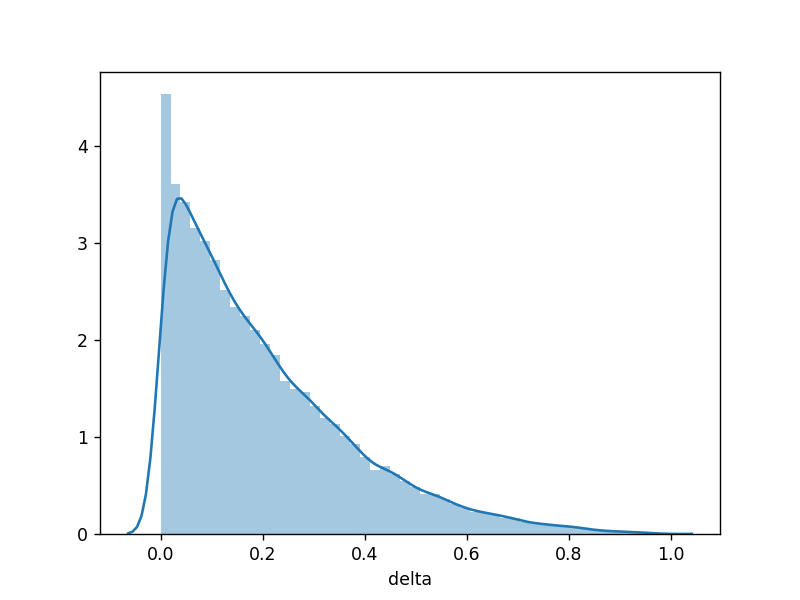

In [50]:
%matplotlib notebook
ax =sns.distplot(trainCmp['delta'])

In [40]:
def rmse( g ):
    
    rmse = np.sqrt( mean_squared_error( g['target'], g['pred_adj_p'] ) )
    return pd.Series( dict( rmse = rmse ) )
rmseTrain=trainCmp.groupby('date').apply(rmse)

<IPython.core.display.Javascript object>


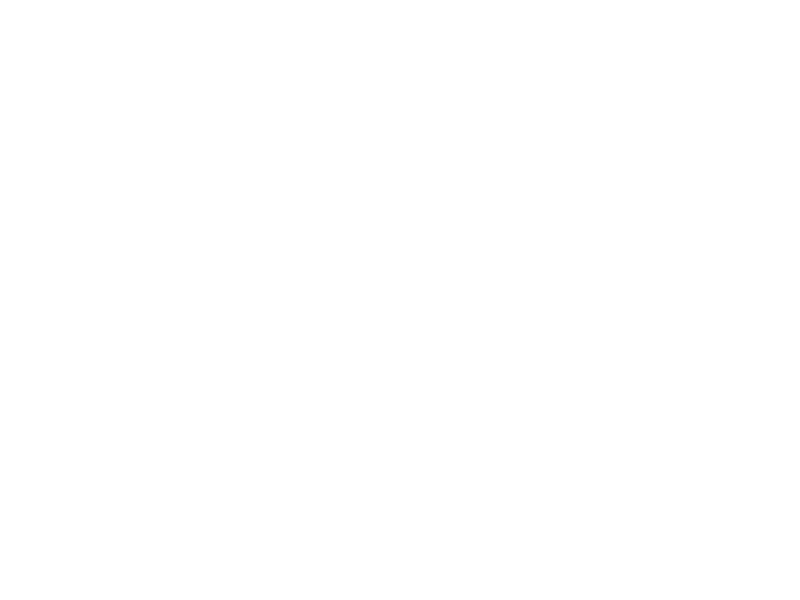

In [41]:
%matplotlib notebook
ax =sns.distplot(rmseTrain)

In [42]:
predictions = (X_test.groupby('date')
               .apply(lambda x: predict(model, x)))

In [43]:
tmp=np.array([])
for i in predictions.to_numpy().reshape(predictions.shape[0],-1):
    tmp=np.concatenate((tmp,i[0]),axis=None)
y_pred_test=pd.Series(data=tmp,index=y_test.index)

In [44]:
#comparison between predicitions and target. Train dataset
testCmp=pd.concat([y_pred_test,y_test],axis=1)
testCmp.columns=['pred','target']
indexTestList=testCmp.index.unique().to_list()
groupSizeTest=pd.DataFrame(data={'groupSize':groups_eval}, index=indexTestList)
testCmp=testCmp.join(groupSizeTest, how='left')
testCmp.index.name='date'

testCmp['pred_adj']=(testCmp.groupby('date').pred.rank()-1)
testCmp['pred_adj_p']=testCmp.pred_adj/(testCmp.groupSize-1)
#trainCmp['pred_adj_p']=trainCmp.groupby('date').pred_adj.rank(pct=True)
testCmp['delta']=abs(testCmp.pred_adj_p-testCmp.target)
np.sqrt(mean_squared_error(testCmp['pred_adj_p'],testCmp['target']))


0.3808350480816757

In [45]:
def rmse( g ):
    
    rmse = np.sqrt( mean_squared_error( g['target'], g['pred_adj_p'] ) )
    return pd.Series( dict( rmse = rmse ) )
rmseTest=testCmp.groupby('date').apply(rmse)
rmseTest

,rmse
date,
2018-07-29,0.354791
2018-09-30,0.401494
2018-10-14,0.390897
2018-12-09,0.380981
2019-01-06,0.393677
2019-03-10,0.377698
2019-04-21,0.408266
2019-08-04,0.389500
2019-09-29,0.373035


<IPython.core.display.Javascript object>


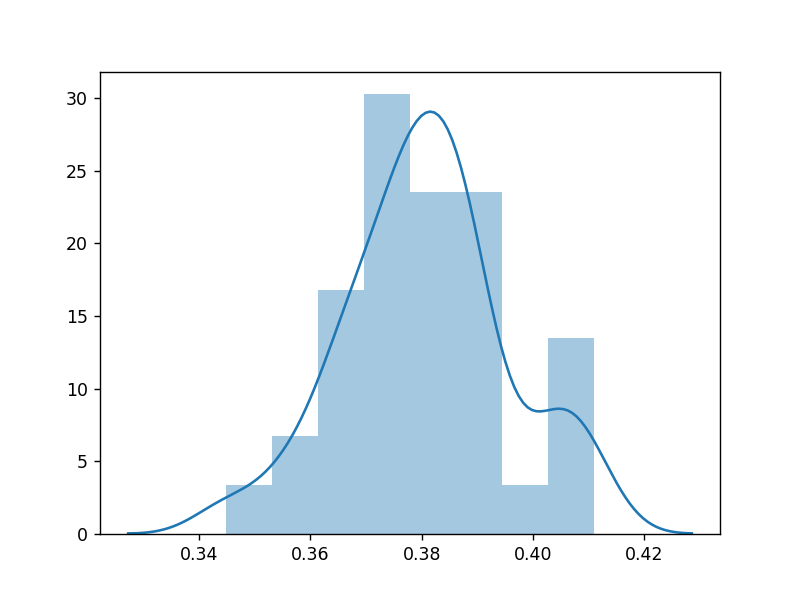

In [51]:
%matplotlib notebook
ax =sns.distplot(rmseTest)

In [47]:
testCmp[['pred_adj_p','target']]

,pred_adj_p,target
date,,
2018-07-29,0.007042,0.000000
2018-07-29,0.732394,0.823944
2018-07-29,0.605634,0.471831
2018-07-29,0.901408,0.816901
2018-07-29,0.683099,0.873239
...,...,...
2021-09-26,0.789809,0.719745
2021-09-26,0.772824,0.057325
2021-09-26,0.059448,0.917197


<IPython.core.display.Javascript object>


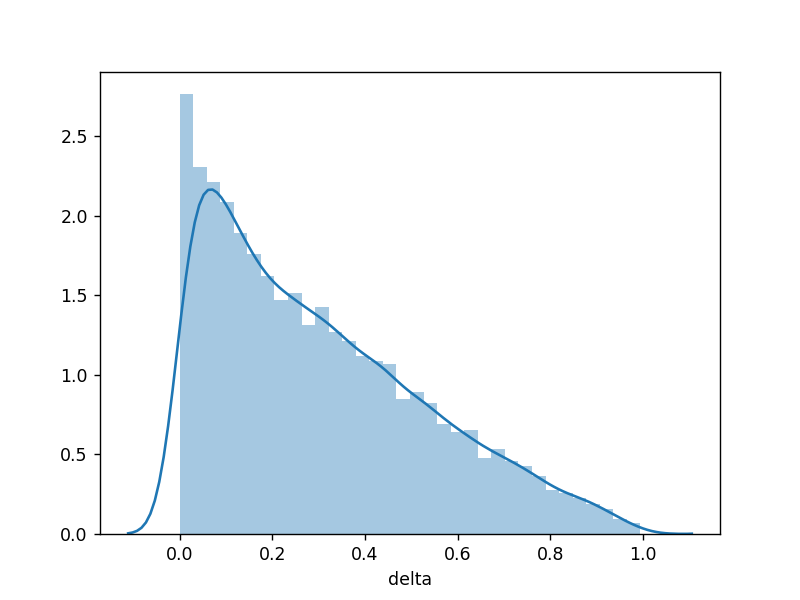

In [48]:
%matplotlib notebook
ax =sns.distplot(testCmp['delta'])

In [49]:
# save to JSON
model.save_model("model1016_4.json")
# save to text format
model.save_model("model1016_4.txt")

In [ ]:
# Use the trained Logistic Regression model to make prediction on latest data

X_validation = validation_dataset.iloc[:, 1:-2]
y_validation = model.predict(X_validation)

#y_validation

In [ ]:
y_validation

In [ ]:
validation_dataset

In [ ]:
predTmp = pd.DataFrame()
predTmp['symbol'] = list(validation_dataset.symbol)
predTmp['prediction'] = y_validation
predTmp['pred_adj']=(predTmp.prediction.rank()-1)/(len(y_validation)-1)
predTmp.head()

In [ ]:
predTmp.pred_adj.max()

%matplotlib notebook
ax =sns.striplot(pre)

In [ ]:
%matplotlib notebook
ax=sns.stripplot(x=predTmp.symbol,y=predTmp.pred_adj)

In [ ]:
predTmp.shape

In [ ]:
prediction=predTmp.copy()
prediction.drop('prediction', axis=1, inplace=True)
prediction.rename(columns={'pred_adj':'prediction'},inplace=True)
prediction

In [ ]:
#check if y_latest is in accordance to shape for submission
if set(prediction.symbol) == set(validation_dataset.symbol):
    print('symbol matched!')
else:
    print('symbol unmatched, the symbol in prediction df must match the symbol in validation_dataset...')
    
if prediction.shape[1] == 2:
    print('column counts ok!')
else:
    print('It should have 2 columns, first column with symbol, second with prediction...')


In [ ]:
#Output submission as .csv file
prediction.to_csv('prediction/prediction_21_40.csv', index = False, header = None)

In [ ]:
%matplotlib notebook
ax=sns.distplot(prediction.prediction)

In [ ]:
prediction[prediction.prediction>0.8]